Installing scikeras

In [ ]:
!pip install scikeras

Importing the libraries

In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scikeras.wrappers import KerasClassifier
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model

Load the dataset

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive

In [ ]:
churn=pd.read_csv('/content/drive/My Drive/Colab Notebooks/CustomerChurn_dataset.csv')

Display basic information about the dataset

In [ ]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
churn.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<ipython-input-100-5887494a39a0>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  churn.info(verbose=True, null_counts=True)


Separating the X and the Y

In [ ]:
X = churn.drop('Churn', axis=1)
y = churn['Churn']

Encoding the X

In [ ]:
# Create a LabelEncoder
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

Scaling the numerical features

In [ ]:
# Scale the numerical features
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

Split the dataset into training and testing sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFECV with the random forest classifier
rfecv = RFECV(estimator=rf_classifier, step=1, cv=5, scoring='accuracy')

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Display the optimal number of features
print("Optimal number of features : {}".format(rfecv.n_features_))

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Display the selected features
print("Selected Features: ", selected_features)

# Fit the random forest classifier on the selected features
rf_classifier.fit(X_train[selected_features], y_train)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': rf_classifier.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)


Optimal number of features : 19
Selected Features:  Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Feature Importances:
             Feature  Importance
5             tenure    0.154359
17    MonthlyCharges    0.144989
18      TotalCharges    0.134193
0         customerID    0.129847
14          Contract    0.082776
8     OnlineSecurity    0.047511
16     PaymentMethod    0.043784
11       TechSupport    0.039644
9       OnlineBackup    0.027703
15  PaperlessBilling    0.023255
1             gender    0.023160
7    InternetService    0.022315
6      MultipleLines    0.021414
3            Partner    0.019762
10  DeviceProtection    0.018749
4         Dependents    0.017289
2      Se

Initializing and fitting into the Random Forest classifier and finding the top 10 features


In [ ]:
# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Display the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Display the selected features
print("Selected Features: ", selected_features)

# Get the top 10 features based on feature importances
top_10_features = feature_importances.head(10)['Feature']

# Display the top 10 features
print("Top 10 Features:")
print(top_10_features)




Optimal number of features: 19
Selected Features:  Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Top 10 Features:
5               tenure
17      MonthlyCharges
18        TotalCharges
0           customerID
14            Contract
8       OnlineSecurity
16       PaymentMethod
11         TechSupport
9         OnlineBackup
15    PaperlessBilling
Name: Feature, dtype: object


In [ ]:
# Assuming top_10_features is the correct set of features
selected_features = top_10_features


The EDA, visualization, and customer profiles

In [ ]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


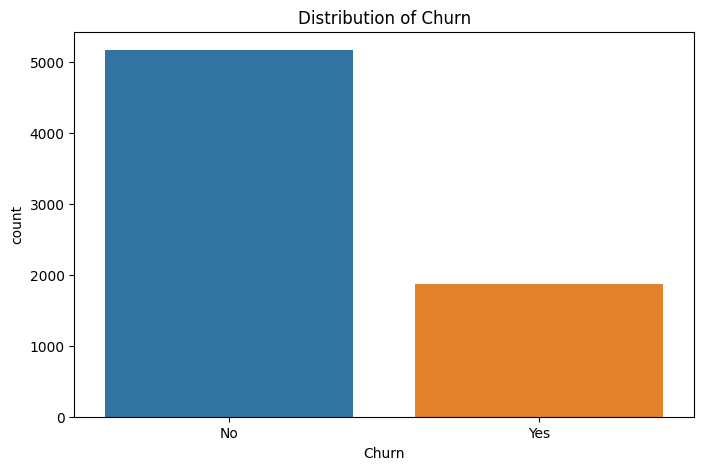

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=churn)
plt.title('Distribution of Churn')
plt.show()

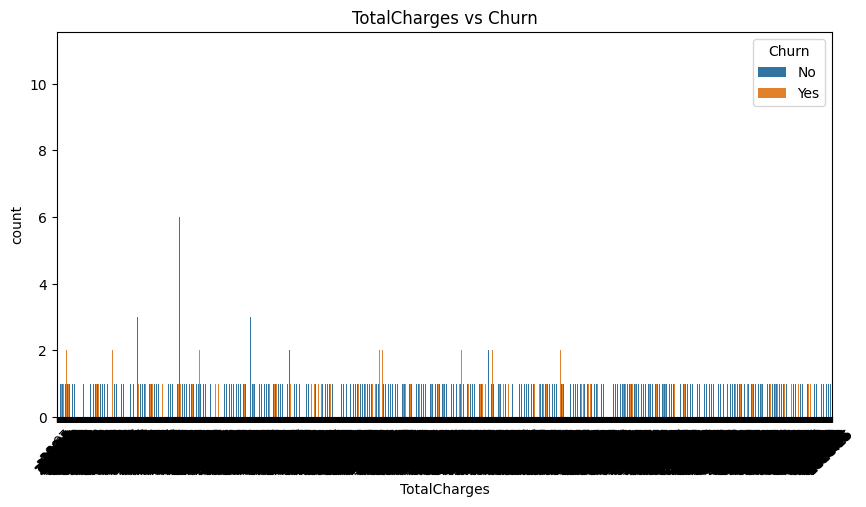

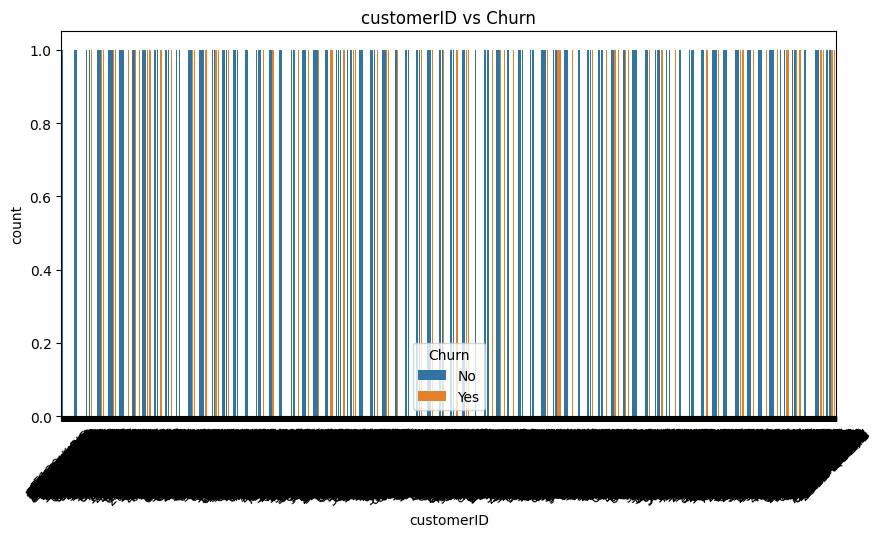

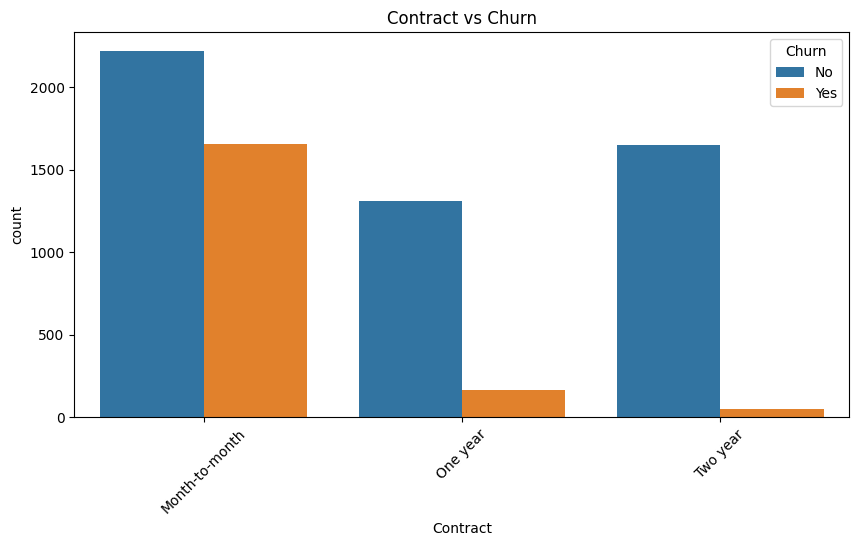

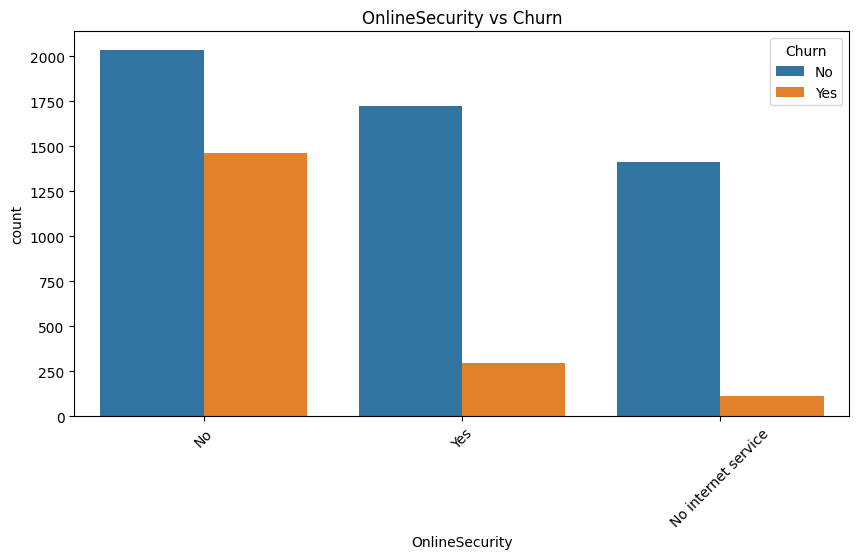

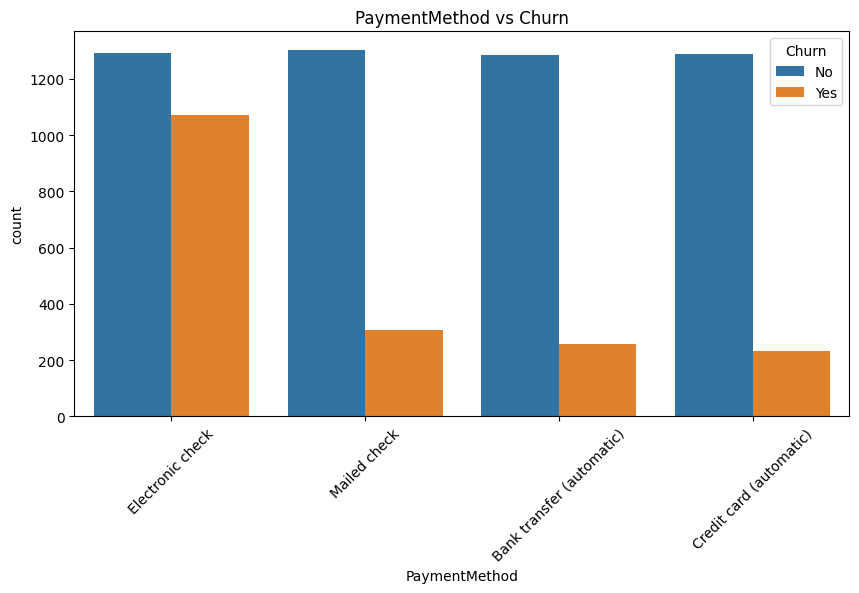

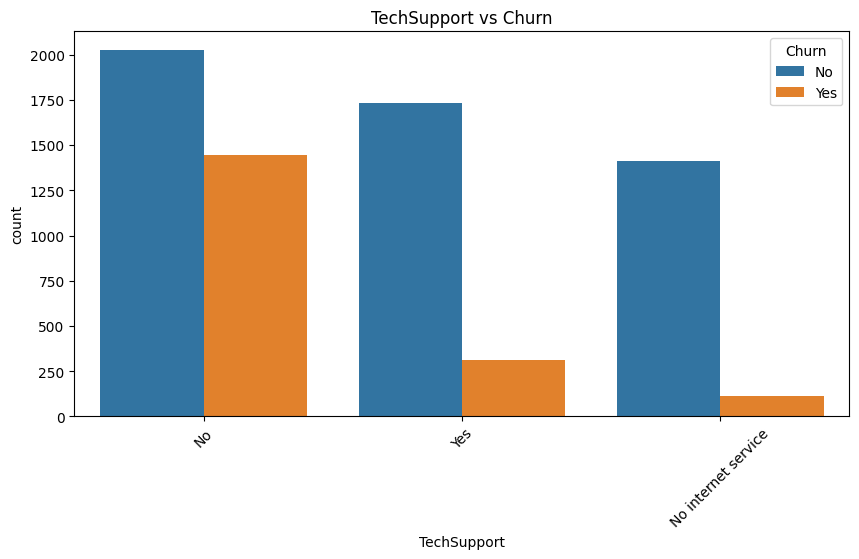

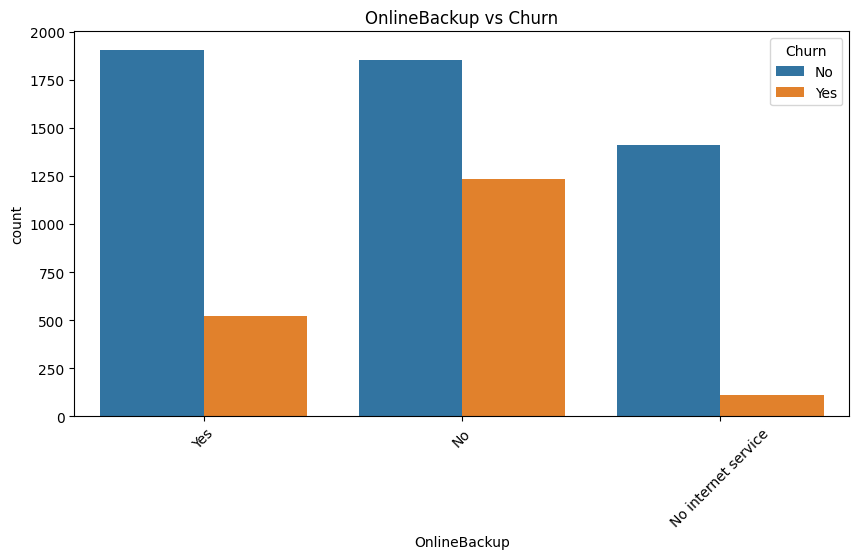

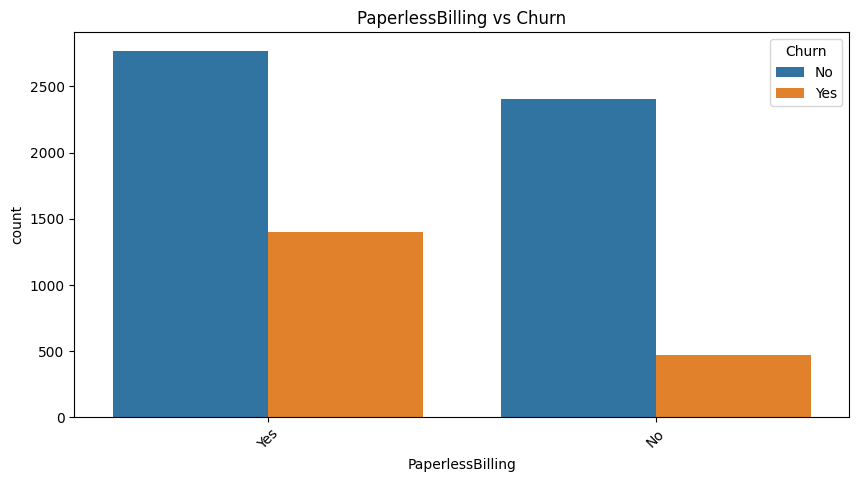

In [ ]:
# Explore relationships between categorical features and churn
categorical_columns = churn[top_10_features].select_dtypes(include=['object']).columns

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, hue='Churn', data=churn)
    plt.title(f'{column} vs Churn')
    plt.xticks(rotation=45)
    plt.show()


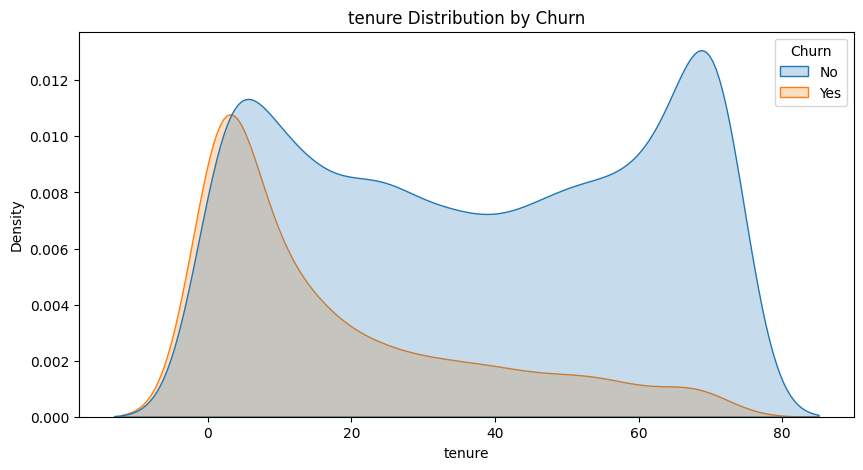

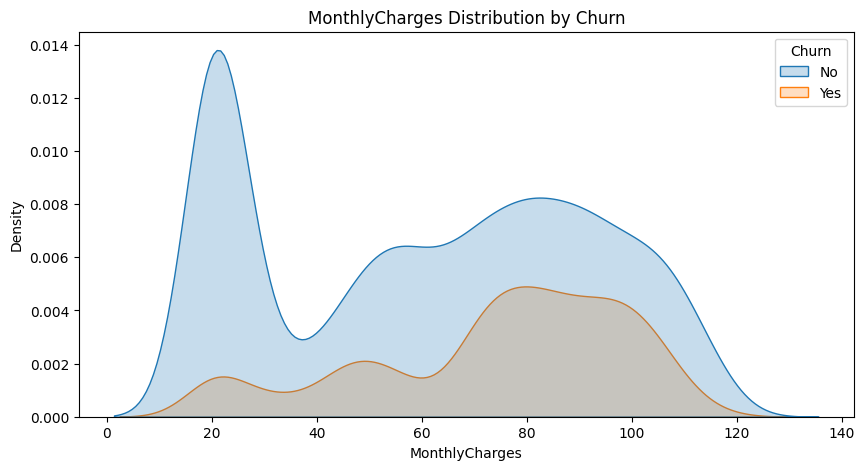

In [ ]:
# Explore relationships between numerical features and churn
numerical_columns = churn[top_10_features].select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(x=column, hue='Churn', data=churn, fill=True)
    plt.title(f'{column} Distribution by Churn')
    plt.show()


Creating the customer profile

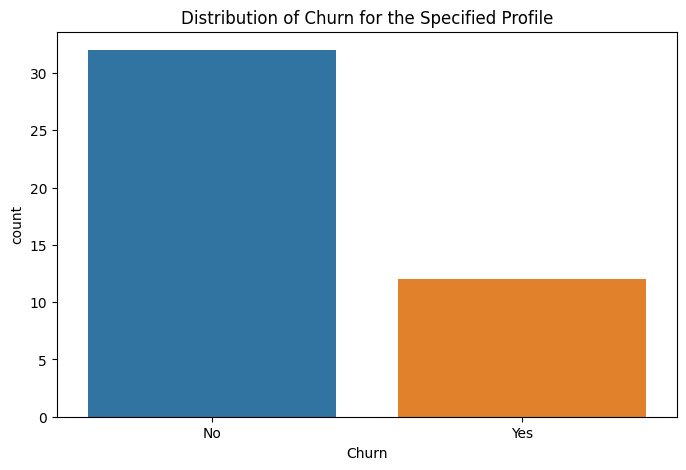

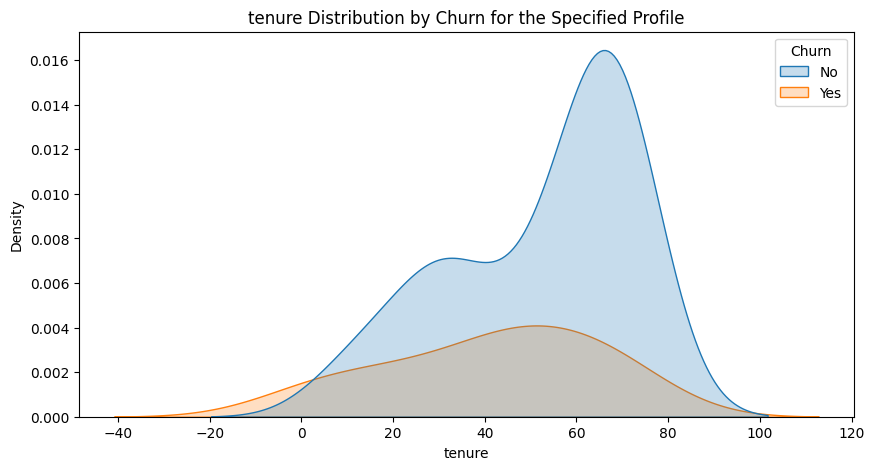

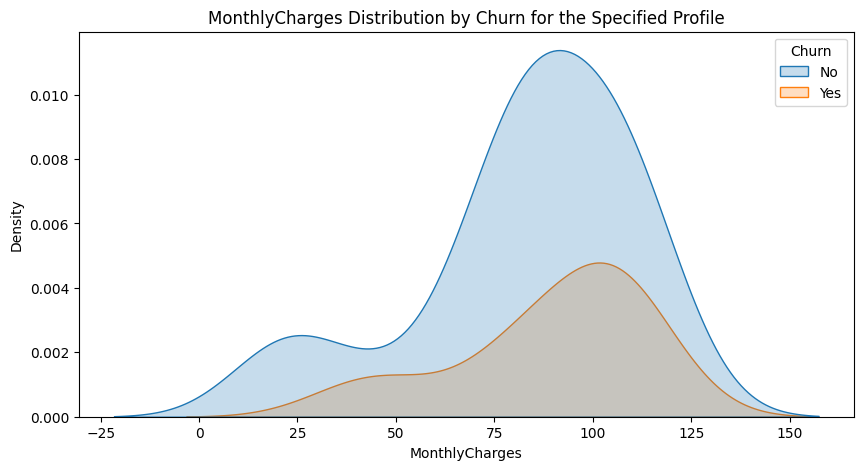

In [ ]:
# Define the customer profile to investigate
profile_to_investigate = {
    'SeniorCitizen': 1,  # Senior citizen
    'gender': 'Male',    # Gender: Male
    'Partner': 'Yes',    # Has a partner
    'Dependents': 'Yes'  # Has dependents
}

# Create a mask for the specified customer profile
mask = (churn['SeniorCitizen'] == profile_to_investigate['SeniorCitizen']) & \
       (churn['gender'] == profile_to_investigate['gender']) & \
       (churn['Partner'] == profile_to_investigate['Partner']) & \
       (churn['Dependents'] == profile_to_investigate['Dependents'])

# Subset the dataset based on the mask
profile_df = churn[mask]

# Visualize the distribution of churn for the specified profile
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=profile_df)
plt.title('Distribution of Churn for the Specified Profile')
plt.show()

# Explore relationships between other features and churn for the specified profile
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(x=column, hue='Churn', data=profile_df, fill=True)
    plt.title(f'{column} Distribution by Churn for the Specified Profile')
    plt.show()


In [ ]:
label_encoder_y = LabelEncoder()
y_train = label_encoder_y.fit_transform(y_train)
y_test = label_encoder_y.transform(y_test)


Create a simple MLP model using Keras and using gridsearch



In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import joblib

def create_mpl_model(input_shape):
    input_layer = Input(shape=(input_shape,))
    hidden_layer_1 = Dense(32, activation='relu')(input_layer)
    hidden_layer_2 = Dense(24, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(12, activation='relu')(hidden_layer_2)
    output_layer = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Assuming X_train[selected_features].shape[1] is the correct input shape
input_shape = X_train[selected_features].shape[1]
model = create_mpl_model(input_shape)

# Fit the model
model.fit(X_train[selected_features], y_train, epochs=30, batch_size=32, validation_data=(X_test[selected_features], y_test))

# Use KerasClassifier for GridSearchCV
keras_classifier = KerasClassifier(build_fn=lambda: model, verbose=0)

# Define grid search parameters
param_grid = {
    'epochs': [20, 30, 40],
    'batch_size': [32, 64, 128],
}

# Create GridSearchCV object
grid_search = GridSearchCV(keras_classifier, param_grid, cv=5, scoring='accuracy')
# Fit GridSearchCV on the training data
grid_search.fit(X_train[selected_features], y_train)


Epoch 1/30
177/177 [==============================] - 2s 7ms/step - loss: 0.7117 - accuracy: 0.4741 - val_loss: 0.6532 - val_accuracy: 0.6217
Epoch 2/30
177/177 [==============================] - 1s 5ms/step - loss: 0.6116 - accuracy: 0.6952 - val_loss: 0.5655 - val_accuracy: 0.7339
Epoch 3/30
177/177 [==============================] - 1s 5ms/step - loss: 0.5421 - accuracy: 0.7348 - val_loss: 0.5059 - val_accuracy: 0.7395
Epoch 4/30
177/177 [==============================] - 1s 6ms/step - loss: 0.4969 - accuracy: 0.7458 - val_loss: 0.4706 - val_accuracy: 0.7622
Epoch 5/30
177/177 [==============================] - 1s 5ms/step - loss: 0.4726 - accuracy: 0.7618 - val_loss: 0.4514 - val_accuracy: 0.7736
Epoch 6/30
177/177 [==============================] - 1s 5ms/step - loss: 0.4591 - accuracy: 0.7707 - val_loss: 0.4401 - val_accuracy: 0.7864
Epoch 7/30
177/177 [==============================] - 1s 5ms/step - loss: 0.4505 - accuracy: 0.7765 - val_loss: 0.4332 - val_accuracy: 0.7970
Epoch 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

GridSearchCV(cv=5,
             estimator=KerasClassifier(build_fn=<function <lambda> at 0x791bd210f520>, verbose=0),
             param_grid={'batch_size': [32, 64, 128], 'epochs': [20, 30, 40]},
             scoring='accuracy')

Using the best keras model and tevaluating the model for the best

In [ ]:
best_keras_model = grid_search.best_estimator_

y_pred = best_keras_model.predict(X_test[selected_features])
y_pred_proba = best_keras_model.predict_proba(X_test[selected_features])[:, 1]


Calculating the accuracy and the auc score

In [ ]:

# Calculate accuracy and AUC score
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("AUC Score:", auc_score)

# Train and test the optimized model again
best_keras_model.fit(X_train[top_10_features], y_train)
y_pred_optimized = best_keras_model.predict(X_test[selected_features])
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print("Accuracy on optimized model:", accuracy_optimized)


Accuracy: 0.7721788502484032
AUC Score: 0.8088958357054872


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Accuracy on optimized model: 0.7743080198722498


Retraining the model based on the best hyper parameters

In [ ]:

# Create GridSearchCV object
grid_search = GridSearchCV(keras_classifier, param_grid, cv=5, scoring='accuracy')
# Fit GridSearchCV on the training data
grid_search.fit(X_train[selected_features], y_train)

# Access the best hyperparameters from the grid_search object
best_params = grid_search.best_params_

# Retrain the model with the best hyperparameters
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']

# Create the model with the best hyperparameters
best_model = create_mpl_model(input_shape)  # No need to specify learning_rate here

# Retrain the model on the entire training set
best_model.fit(X_train[selected_features], y_train, epochs=best_epochs, batch_size=best_batch_size)

# Evaluate the retrained model on the test set
y_pred_retrained = best_model.predict(X_test[selected_features])
y_pred_proba_retrained = y_pred_retrained  # Since there's no predict_proba, use the raw output as probabilities

# Calculate accuracy and AUC score for the retrained model
accuracy_retrained = accuracy_score(y_test, y_pred_retrained.round())  # Adjusted to use rounded predictions
auc_score_retrained = roc_auc_score(y_test, y_pred_proba_retrained)

print("Accuracy on Retrained Model:", accuracy_retrained)
print("AUC Score on Retrained Model:", auc_score_retrained)


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Epoch 1/20
45/45 [==============================] - 1s 5ms/step - loss: 0.7135 - accuracy: 0.4808
Epoch 2/20
45/45 [==============================] - 0s 5ms/step - loss: 0.6775 - accuracy: 0.5442
Epoch 3/20
45/45 [==============================] - 0s 5ms/step - loss: 0.6481 - accuracy: 0.6095
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6557
Epoch 5/20
45/45 [==============================] - 0s 5ms/step - loss: 0.5993 - accuracy: 0.6841
Epoch 6/20
45/45 [==============================] - 0s 4ms/step - loss: 0.5784 - accuracy: 0.7084
Epoch 7/20
45/45 [==============================] - 0s 4ms/step - loss: 0.5597 - accuracy: 0.7206
Epoch 8/20
45/45 [==============================] - 0s 4ms/step - loss: 0.5429 - accuracy: 0.7265
Epoch 9/20
45/45 [==============================] - 0s 4ms/step - loss: 0.5286 - accuracy: 0.7311
Epoch 10/20
45/45 [==============================] - 0s 5ms/step - loss: 0.5167 - accuracy: 0.7368
Epoch 11/20
45/45 [

Saving the model to a pickle file

In [ ]:
import joblib

# Save the model using joblib
joblib.dump(best_model, '/content/drive/My Drive/Colab Notebooks/Churn_Mod.pkl')


In [ ]:
joblib.dump(label_encoder, ' /content/drive/My Drive/Colab Notebooks/label_encoded.pkl')

In [ ]:
history = model.fit(X_train[selected_features], y_train, epochs=30, batch_size=32, validation_data=(X_test[selected_features], y_test))

# Print accuracy and loss over epochs
print("Training Accuracy:", history.history['accuracy'])
print("Training Loss:", history.history['loss'])

# Print validation accuracy and loss over epochs
print("Validation Accuracy:", history.history['val_accuracy'])
print("Validation Loss:", history.history['val_loss'])


Epoch 1/30
177/177 [==============================] - 1s 7ms/step - loss: 0.2821 - accuracy: 0.8701 - val_loss: 0.6017 - val_accuracy: 0.7502
Epoch 2/30
177/177 [==============================] - 1s 5ms/step - loss: 0.2821 - accuracy: 0.8722 - val_loss: 0.6035 - val_accuracy: 0.7551
Epoch 3/30
177/177 [==============================] - 1s 3ms/step - loss: 0.2815 - accuracy: 0.8727 - val_loss: 0.6034 - val_accuracy: 0.7594
Epoch 4/30
177/177 [==============================] - 1s 3ms/step - loss: 0.2809 - accuracy: 0.8727 - val_loss: 0.6024 - val_accuracy: 0.7608
Epoch 5/30
177/177 [==============================] - 1s 3ms/step - loss: 0.2813 - accuracy: 0.8717 - val_loss: 0.6033 - val_accuracy: 0.7566
Epoch 6/30
177/177 [==============================] - 1s 3ms/step - loss: 0.2805 - accuracy: 0.8720 - val_loss: 0.6018 - val_accuracy: 0.7601
Epoch 7/30
177/177 [==============================] - 1s 4ms/step - loss: 0.2805 - accuracy: 0.8724 - val_loss: 0.6051 - val_accuracy: 0.7516
Epoch 